In [1]:
import pandas as pd

from plotnine import *

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as rvectors
from rpy2.robjects import pandas2ri

import scipy as sp
import statsmodels as sm

%matplotlib inline
r = ro.r

Activate the pandas conversion for rpy2. See, https://pandas.pydata.org/pandas-docs/stable/r_interface.html

In [2]:
pandas2ri.activate()

Import the R packages that will be used in this analysis.

In [3]:
packageNames = ('afex', 'lsmeans', 'coin')
 
if all(rpackages.isinstalled(x) for x in packageNames):
    have_packages = True
else:
   have_packages = False
 
if not have_packages:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]
 
    if len(packnames_to_install) > 0: 
        utils.install_packages(rvectors.StrVector(packnames_to_install))

In [4]:
lsm  = rpackages.importr('lsmeans')
afex = rpackages.importr('afex') 
coin = rpackages.importr('coin')

t_test = ro.r('t.test')
friedman_test = ro.r('friedman.test')
wilcox_test = ro.r('wilcox.test')
p_adjust = ro.r('p.adjust')

Set the theme to use in plotnine.

In [5]:
theme_set(theme_xkcd())

In [6]:
df = pd.read_csv("websearch2.csv")
df.Subject = df.Subject.astype('category')
df.Searches = df.Searches.astype(int)
df.Engine = df.Engine.astype('category')
df.Effort = df.Effort.astype('category')
df['EffortOrdinal'] = df.Effort.astype(int)

In [7]:
df.tail(5)

,Subject,Engine,Order,Searches,Effort,EffortOrdinal
55,28,Bing,1,192,4,4
56,29,Google,1,162,5,5
57,29,Bing,2,163,3,3
58,30,Google,2,146,5,5
59,30,Bing,1,137,2,2


In [8]:
df.groupby(['Engine']).describe()

EffortOrdinal                                              Order       \
               count      mean       std  min  25%  50%  75%  max count mean   
Engine                                                                         
Bing            30.0  4.066667  1.760355  1.0  2.0  4.0  6.0  7.0  30.0  1.5   
Google          30.0  3.733333  1.740657  1.0  2.0  4.0  5.0  7.0  30.0  1.5   

        ...             Searches                                               \
        ...    75%  max    count        mean        std    min     25%    50%   
Engine  ...                                                                     
Bing    ...    2.0  2.0     30.0  165.966667  32.082312   89.0  144.25  164.0   
Google  ...    2.0  2.0     30.0  147.833333  24.418878  108.0  131.00  147.5   

                       
           75%    max  
Engine                 
Bing    184.75  241.0  
Google  161.75  198.0  

[2 rows x 24 columns]

Determine how many subjects took part in this experiment?

In [9]:
df.Subject.nunique()

30

Determine the average number of searches required for the search engine that had the greatest average overall?

In [10]:
df.groupby(['Engine']).Searches.mean()

Engine
Bing      165.966667
Google    147.833333
Name: Searches, dtype: float64

Display histograms of Searches by search engine.

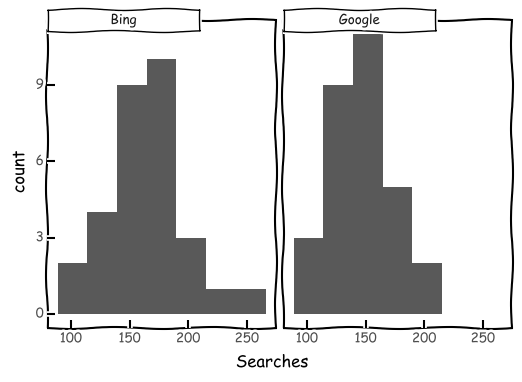

<ggplot: (293452221)>

In [11]:
(
    ggplot(df) +
    aes(x='Searches') +
    geom_histogram(binwidth=2) +
    stat_bin(bins=7) +
    facet_wrap('~Engine')
)

Display box plots of searches by search engine.

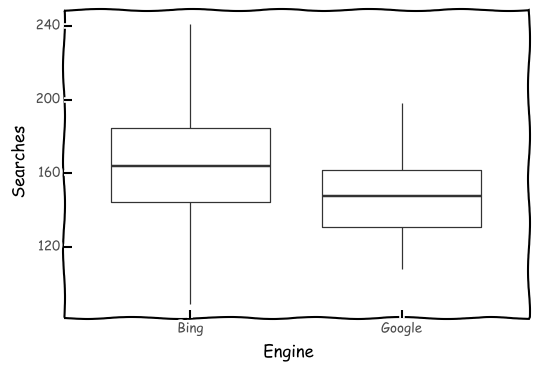

<ggplot: (297021453)>

In [12]:
(
    ggplot(df, aes(x='Engine', y='Searches')) +
    geom_boxplot()
)

Test for normality within each search engine type using Shapiro-Wilk.

https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.shapiro.html

In [13]:
groups = df.sort_values('Subject').groupby(['Engine'])
groups.Searches.apply(lambda x : sp.stats.shapiro(x))

Engine
Bing      (0.983305990696, 0.904959201813)
Google    (0.970467865467, 0.552055418491)
Name: Searches, dtype: object

Test for homoscedasticity within search engine using Levene test for equal variances by Engine. See, https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html

In [14]:
groups = df.sort_values('Subject').groupby(['Engine'])
sp.stats.levene(*[groups.get_group(x).Searches for x in groups.groups], center='median')

LeveneResult(statistic=1.1082233526291065, pvalue=0.29683458221224279)

Conduct and order effect test between search engine using a paired-samples t-test assuming equal variances. See, https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.ttest_rel.html

In [15]:
groups = df.sort_values('Subject').groupby(['Order'])
sp.stats.ttest_rel(*[groups.get_group(x).Searches for x in groups.groups])

Ttest_relResult(statistic=0.34272743120005489, pvalue=0.73427539064431357)

Conduct a paired-samples t-test, assuming equal variances, on Searches by Engine.

In [16]:
groups = df.sort_values('Subject').groupby(['Engine'])
sp.stats.ttest_rel(*[groups.get_group(x).Searches for x in groups.groups])

Ttest_relResult(statistic=2.5020772424994786, pvalue=0.018237582098993173)

Conduct a nonparametric Wilcoxon signed-rank test on the Effort Likert-type ratings.

Using scipy see, https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.wilcoxon.html. However, the scipy result is not the same as the R result.

In [17]:
# Wilcox test using sp.stats.wilcoxon
#(statistic, pvalue) = sp.stats.wilcoxon(*[groups.get_group(x).EffortOrdinal for x in groups.groups])
#print('p-value: %s' % pvalue)

print coin.wilcoxsign_test(ro.Formula('EffortOrdinal ~ Engine | Subject'), df, distribution='exact')


	Exact Wilcoxon-Pratt Signed-Rank Test

data:  y by x (pos, neg) 
	 stratified by block
Z = 0.68343, p-value = 0.5016
alternative hypothesis: true mu is not equal to 0




Read websearch3.csv.

In [18]:
df = pd.read_csv("websearch3.csv")
df.Subject = df.Subject.astype('category')
df.Searches = df.Searches.astype(int)
df.Engine = df.Engine.astype('category')
df.Effort = df.Effort.astype('category')
df.Order = df.Order.astype('category')
df['EffortOrdinal'] = df.Effort.astype(int)

In [19]:
df.tail(5)

,Subject,Engine,Order,Searches,Effort,EffortOrdinal
85,29,Bing,1,195,4,4
86,29,Yahoo,2,182,5,5
87,30,Google,3,152,1,1
88,30,Bing,2,188,7,7
89,30,Yahoo,1,131,3,3


In [20]:
df.groupby(['Engine']).describe()

EffortOrdinal                                              Searches  \
               count      mean       std  min  25%  50%  75%  max    count   
Engine                                                                       
Bing            30.0  3.900000  1.626293  1.0  3.0  4.0  5.0  7.0     30.0   
Google          30.0  3.866667  1.925032  1.0  3.0  4.0  5.0  7.0     30.0   
Yahoo           30.0  5.000000  1.389617  3.0  4.0  5.0  6.0  7.0     30.0   

                                                                    
              mean        std    min     25%    50%     75%    max  
Engine                                                              
Bing    159.833333  30.595338  104.0  136.75  161.5  180.75  214.0  
Google  152.666667  24.562845   93.0  137.50  152.0  168.50  200.0  
Yahoo   172.400000  37.826829   92.0  141.75  169.5  190.75  236.0

Determine many subjects took part in this new experiment?

In [21]:
df.Subject.nunique()

30

Determine the average number of searches required for the search engine that had the greatest average overall?

In [22]:
df.groupby(['Engine']).Searches.mean()

Engine
Bing      159.833333
Google    152.666667
Yahoo     172.400000
Name: Searches, dtype: float64

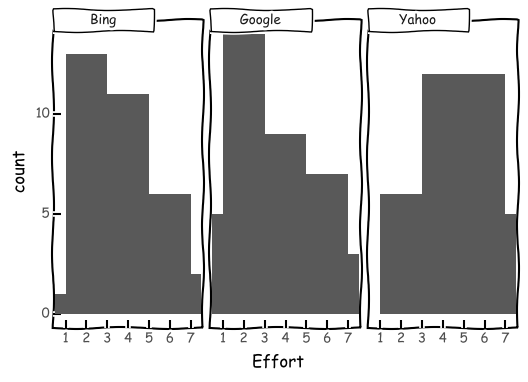

<ggplot: (297028593)>

In [23]:
(
    ggplot(df) +
    aes(x='Effort') +
    geom_histogram(binwidth=2) +
    stat_bin(bins=7) +
    facet_wrap('~Engine') + 
    theme_xkcd()
)

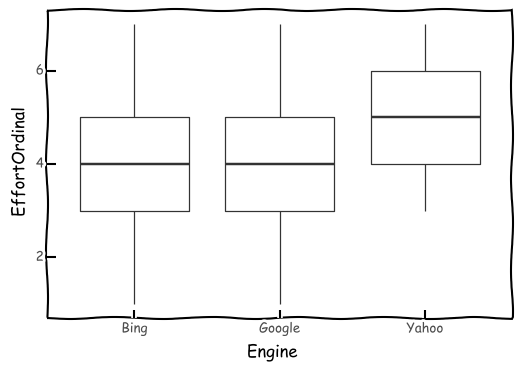

<ggplot: (297210497)>

In [24]:
(
    ggplot(df, aes(x='Engine', y='EffortOrdinal')) +
    geom_boxplot()
)

Conduct a repreated measures ANOVA to determine if there was an order effect on Searches.

Import the R afex package.

In [25]:
model = afex.aov_ez(id='Subject', dv='Searches', data=df, within=['Order'])
print(r.summary(model))


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                 SS num Df Error SS den Df         F Pr(>F)    
(Intercept) 2351280      1    25351     29 2689.7318 <2e-16 ***
Order          2567      2    64207     58    1.1594 0.3208    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

      Test statistic p-value
Order        0.94165 0.43096


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

       GG eps Pr(>F[GG])
Order 0.94486      0.319

        HF eps Pr(>F[HF])
Order 1.008692   0.320849



Conduct a repeated measures ANOVA on Searches by Engine.

In [26]:
model = afex.aov_ez(id='Subject', dv='Searches', data=df, within=['Engine'])
afex.summary_afex_aov(model)
print(r.summary(model))


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

                 SS num Df Error SS den Df         F Pr(>F)    
(Intercept) 2351280      1    25351     29 2689.7318 <2e-16 ***
Engine         5987      2    60787     58    2.8562 0.0656 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

       Test statistic p-value
Engine        0.94203 0.43343


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

        GG eps Pr(>F[GG])  
Engine 0.94521    0.06895 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

         HF eps Pr(>F[HF])
Engine 1.009098 0.06560302



In [27]:
pairwise = lsm.lsmeans(model, "Engine", contr="pairwise", adjust="holm")
print(r.summary(pairwise))

$lsmeans
 Engine   lsmean       SE    df lower.CL upper.CL
 Bing   159.8333 5.744831 86.41 148.4138 171.2529
 Google 152.6667 5.744831 86.41 141.2471 164.0862
 Yahoo  172.4000 5.744831 86.41 160.9804 183.8196

Confidence level used: 0.95 

$contrasts
 contrast         estimate       SE df t.ratio p.value
 Bing - Google    7.166667 8.358844 58   0.857  0.3948
 Bing - Yahoo   -12.566667 8.358844 58  -1.503  0.2763
 Google - Yahoo -19.733333 8.358844 58  -2.361  0.0649

P value adjustment: holm method for 3 tests 




Whatever your previous answer, proceed to do post hoc pairwise comparisons. Conduct manual pairwise comparisons of Searches among levels of Engine using paired-samples t-tests, assuming equal variances and using Holm's sequential Bonferroni procedure to correct for multiple comparisons. 

In [37]:
groups = df.sort_values('Subject').groupby(['Engine'])

# Use scipy t-test and adjustment.
#pvals = [None]*3
#pvals[0] = sp.stats.ttest_ind(groups.get_group('Bing').Searches,
#                              groups.get_group('Google').Searches)[1]
#pvals[1] = sp.stats.ttest_ind(groups.get_group('Bing').Searches,
#                              groups.get_group('Yahoo').Searches)[1]
#pvals[2] = sp.stats.ttest_ind(groups.get_group('Google').Searches,
#                              groups.get_group('Yahoo').Searches)[1]

#(reject, pvals_corrected, _, _) = sm.sandbox.stats.multicomp.multipletests(pvals, method='holm')
#print min(pvals_corrected)

# Use R t-test and adjustment.
pvals[0] = t_test(groups.get_group('Bing').Searches,
                  groups.get_group('Google').Searches, paired=True, var_equal=True)[2]
pvals[1] = t_test(groups.get_group('Bing').Searches,
                  groups.get_group('Yahoo').Searches, paired=True, var_equal=True)[2]
pvals[2] = t_test(groups.get_group('Google').Searches,
                  groups.get_group('Yahoo').Searches, paired=True, var_equal=True)[2]

pvals_corrected = p_adjust(pvals, method='holm')
print min(pvals_corrected)

0.0506671406499


Conduct a nonparametric Friedman test on the Effort Likert-type ratings. Calculate an asymptotic p-value. To the nearest ten-thousandth (four digits), what is the Chi-Square statistic from such a

In [29]:
groups = df.sort_values('Subject').groupby(['Engine'])

measurements = [groups.get_group(x).Effort for x in groups.groups]

# Use scipy friedman test.
(statistic, pvalue) = sp.stats.friedmanchisquare(*measurements)

# Use R friedman test.
#x = pd.DataFrame()
#x['0'] = measurements[0].as_matrix()
#x['1'] = measurements[1].as_matrix()
#x['2'] = measurements[2].as_matrix()
#(statistic, parameter, pvalue, method, _) = friedman_test(x.as_matrix(), distribution='asymptotic')

statistic

8.0181818181818425

Whatever your previous answer, proceed to do post hoc pairwise comparisons. Conduct manual pairwise comparisons of Effort among levels of Engine with Wilcoxon signed-rank tests, using Holm's sequential Bonferroni procedure to correct for multiple comparisons. 

In [30]:
groups = df.sort_values('Subject').groupby(['Engine'])

a = ro.FloatVector(groups.get_group('Bing').Effort)
b = ro.FloatVector(groups.get_group('Google').Effort)
c = ro.FloatVector(groups.get_group('Yahoo').Effort)

pvals = [None]*3
pvals[0] = wilcox_test(a, b, paired=True, exact=False)[2]
pvals[1] = wilcox_test(a, c, paired=True, exact=False)[2]
pvals[2] = wilcox_test(b, c, paired=True, exact=False)[2]

adjusted_pvals = p_adjust(pvals, method="holm")
min(adjusted_pvals)

0.03085189532524923

# References

1. http://benalexkeen.com/comparative-statistics-in-python-using-scipy/
2. https://www.marsja.se/repeated-measures-anova-using-python/
3. https://www.youtube.com/watch?v=IXavu8skv9I
4. http://pythonplot.com/
5. https://www.r-statistics.com/tag/friedman-test/

# Answers

1. 30
2. 165.97
3. 0.7343
4. 2.5021
5. 0.5016
6. 30
7. 172.40
8. 0.94165
9. 0.3208
10. 0.942
11. 0.0656
12. No
13. 0.0507
14. 8.0182
15. Yes
16. 0.0309